In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete3VGNPX/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:

def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )
#print(list(train_dataset.take(1).as_numpy_iterator()),
 #     list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))


# Dataset Visualization

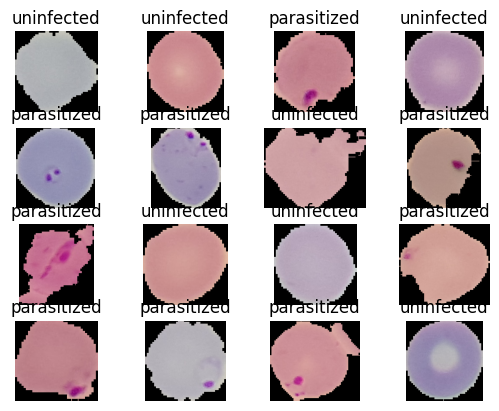

In [ ]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features["label"].int2str(label))
  plt.axis("off")

# Data Preprocessig

In [ ]:
IM_SIZE = 224

def resizing_rescale(image, label):
    # Resize the image to (IM_SIZE, IM_SIZE)
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))
    # Rescale the image values to the range [0, 1]
    image = image / 255.0
    return image, label

In [ ]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [ ]:
train_dataset = (
    train_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
  ).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
val_dataset = (
    val_dataset
    .shuffle(buffer_size = 8, reshuffle_each_iteration = True)
  ).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [16]:
model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(
    filters=6,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="sigmoid"
),
                BatchNormalization()
,

        MaxPool2D(
    pool_size=2,
    strides=2,
        ),

   Conv2D(
    filters=16,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="sigmoid"

),
                BatchNormalization()
,


        MaxPool2D(
    pool_size=2,
    strides=2,
        ),

        Flatten(),

        Dense(100, activation="sigmoid"),
        BatchNormalization(),
         Dense(10, activation="sigmoid"),
         BatchNormalization(),
         Dense(2, activation="sigmoid")
          ]
)

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_2 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_3 (Batc  (None, 109, 109, 16)     64        
 hNormalization)                                                 
                                                      

In [17]:
y_true = [0, 1, 0, 0]
y_pred = [0.6, 0.51, 0.94,1]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0227046>

In [18]:
from keras.losses import MeanAbsoluteError
model.compile(optimizer=Adam(learning_rate=0.1),
              loss=MeanAbsoluteError(),
              metrics="accuracy"
              )


In [19]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
689/689 [==============================] - 52s 70ms/step - loss: 0.5003 - accuracy: 0.5000 - val_loss: 0.4940 - val_accuracy: 0.5060
Epoch 2/10
689/689 [==============================] - 47s 68ms/step - loss: 0.4999 - accuracy: 0.5001 - val_loss: 0.4947 - val_accuracy: 0.5053
Epoch 3/10
689/689 [==============================] - 45s 66ms/step - loss: 0.5000 - accuracy: 0.5000 - val_loss: 0.4958 - val_accuracy: 0.5042
Epoch 4/10
689/689 [==============================] - 46s 67ms/step - loss: 0.4999 - accuracy: 0.5001 - val_loss: 0.4933 - val_accuracy: 0.5067
Epoch 5/10
689/689 [==============================] - 46s 67ms/step - loss: 0.4999 - accuracy: 0.5001 - val_loss: 0.4951 - val_accuracy: 0.5049
Epoch 6/10
689/689 [==============================] - 57s 83ms/step - loss: 0.4999 - accuracy: 0.5001 - val_loss: 0.4929 - val_accuracy: 0.5071
Epoch 7/10
689/689 [==============================] - 47s 68ms/step - loss: 0.4999 - accuracy: 0.5001 - val_loss: 0.4926 - val_accuracy:

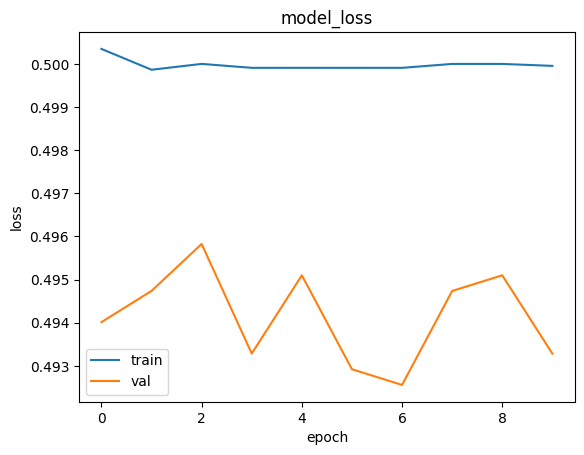

In [20]:
import matplotlib.pyplot as plt

# Check if 'val_loss' is in history.history
if 'val_loss' in history.history:
    # Plot both training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
else:
    # If 'val_loss' is not found, only plot training loss
    plt.plot(history.history['loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

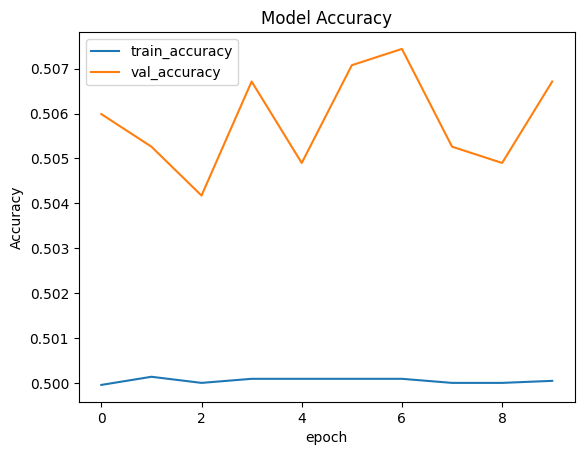

In [22]:
import matplotlib.pyplot as plt

# Check if 'val_loss' is in history.history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()


# Model evaluation and Test

In [24]:
test_dataset = test_dataset.batch(1)

In [25]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 24s 4ms/step - loss: 0.5053 - accuracy: 0.4947


[0.5052592754364014, 0.49474066495895386]

In [26]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 18s 18s/step


0.9999939

In [27]:
def parasite_or_not(x):
  if x<0.5:
    return str("P")
  else:
    return str("U")

In [28]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 12s 12s/step


'U'

1/1 [==============================] - 0s 17ms/step


(0.0, 1.0, 0.0, 1.0)

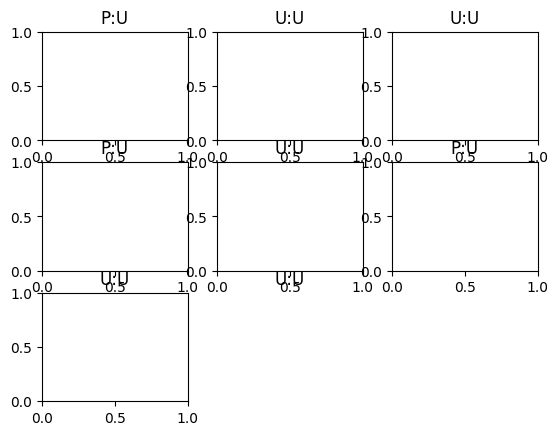

In [30]:
for i, (image, label) in enumerate(test_dataset.take(8)):
  ax = plt.subplot(3, 3, i+1)
  #plt.imshow(image)
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

plt.axis("off")

# Functional API

In [44]:
IM_SIZE=224
func_input = starting_block = tf.keras.layers.Input(shape=(IM_SIZE, IM_SIZE, 3), name="Input Image")


In [45]:
x =  Conv2D(
    filters=6,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"
)(func_input)

x = BatchNormalization()(x)

x = MaxPool2D(
    pool_size=2,
    strides=2,
        )(x)

x = Conv2D(
    filters=16,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"

)(x)

x = BatchNormalization()(x)

x = MaxPool2D(
    pool_size=2,
    strides=2,
        )(x)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation="sigmoid")(x)

model_func = Model(func_input, func_output, name='Model1')
model_func.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_38 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_39 (Bat  (None, 109, 109, 16)     64   

In [46]:
from keras.losses import MeanAbsoluteError
model_func.compile(optimizer=Adam(learning_rate=0.1),
              loss=BinaryCrossentropy(),
              metrics="accuracy"
              )


In [47]:
history = model_func.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1)

Epoch 1/10
689/689 [==============================] - 64s 88ms/step - loss: 0.6182 - accuracy: 0.6711 - val_loss: 19.4824 - val_accuracy: 0.5125
Epoch 2/10
689/689 [==============================] - 44s 64ms/step - loss: 0.5175 - accuracy: 0.7440 - val_loss: 1.6860 - val_accuracy: 0.4962
Epoch 3/10
689/689 [==============================] - 53s 76ms/step - loss: 0.2634 - accuracy: 0.9191 - val_loss: 0.4874 - val_accuracy: 0.7757
Epoch 4/10
689/689 [==============================] - 52s 76ms/step - loss: 0.2385 - accuracy: 0.9261 - val_loss: 0.2536 - val_accuracy: 0.9114
Epoch 5/10
689/689 [==============================] - 50s 73ms/step - loss: 0.2261 - accuracy: 0.9331 - val_loss: 0.3753 - val_accuracy: 0.9085
Epoch 6/10
689/689 [==============================] - 53s 77ms/step - loss: 0.2181 - accuracy: 0.9365 - val_loss: 0.2873 - val_accuracy: 0.9143
Epoch 7/10
689/689 [==============================] - 46s 67ms/step - loss: 0.2031 - accuracy: 0.9417 - val_loss: 0.2305 - val_accuracy

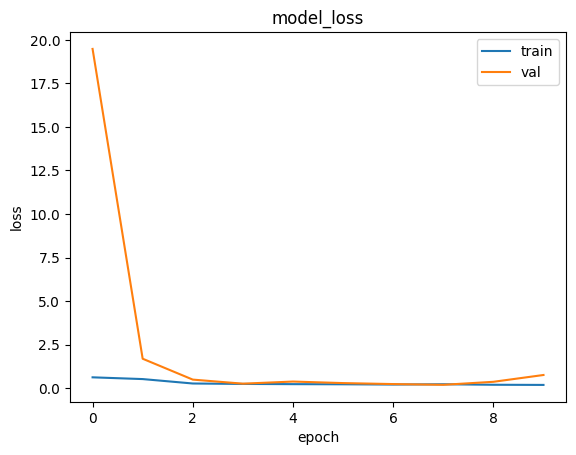

In [48]:
import matplotlib.pyplot as plt

# Check if 'val_loss' is in history.history
if 'val_loss' in history.history:
    # Plot both training and validation loss
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
else:
    # If 'val_loss' is not found, only plot training loss
    plt.plot(history.history['loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

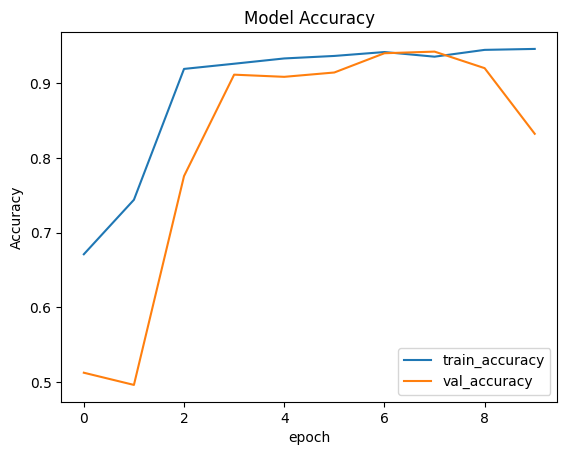

In [49]:
import matplotlib.pyplot as plt

# Check if 'val_loss' is in history.history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()


In [51]:
x =  Conv2D(
    filters=6,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"
)(func_input)

x = BatchNormalization()(x)

x = MaxPool2D(
    pool_size=2,
    strides=2,
        )(x)

x = Conv2D(
    filters=16,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"

)(x)

x = BatchNormalization()(x)

output = MaxPool2D(
    pool_size=2,
    strides=2,
        )(x)



feature_extractor_model = Model(func_input, output, name='Feature_Extractor')
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_44 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_45 (Bat  (None, 109, 109, 16

In [52]:
x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation="sigmoid")(x)

model_func = Model(func_input, func_output, name='Model1')
model_func.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_11 (Flatten)        (None, 46656)             0         
                                                                 
 dense_33 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_46 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_34 (Dense)            (None, 10)                1010 

Sequential

In [53]:
feature_extractor_sequential_model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    Conv2D(
    filters=6,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"
),
        BatchNormalization()
        ,
        MaxPool2D(
    pool_size=2,
    strides=2,
        ),


            Conv2D(
    filters=16,
    kernel_size=3,
    strides=1,
    padding='valid',
    activation="relu"
),

        BatchNormalization()
        ,
        MaxPool2D(
    pool_size=2,
    strides=2,
        ),

          ]
)

feature_extractor_sequential_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_48 (Bat  (None, 222, 222, 6)      24        
 chNormalization)                                                
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 111, 111, 6)      0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_49 (Bat  (None, 109, 109, 16)     64        
 chNormalization)                                                
                                                      

In [54]:
x = feature_extractor_sequential_model(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation="sigmoid")(x)

model_func = Model(func_input, func_output, name='Model1')
model_func.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten_12 (Flatten)        (None, 46656)             0         
                                                                 
 dense_36 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_50 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_37 (Dense)            (None, 10)                1010      
                                                            

# Model Subclassing

In [64]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    strides=strides,
    padding=padding,
    activation=activation
    )

    self.batch_1 = BatchNormalization()

    self.pool_1 = MaxPool2D(
    pool_size=pool_size,
    strides=2*strides,
        )

    self.conv_2 =  Conv2D(
    filters=filters*2,
    kernel_size=kernel_size,
    strides=strides,
    padding=padding,
    activation=activation
    )

    self.batch_2 = BatchNormalization()

    self.pool_2 = MaxPool2D(
    pool_size=pool_size,
    strides=2*strides,
        )

  def call(self, x):
    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x
feature_subclassed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)
feature_subclassed

In [65]:
x = feature_subclassed(func_input)

x = Flatten()(x)

x = Dense(100, activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10, activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1, activation="sigmoid")(x)

model_func = Model(func_input, func_output, name='Model1')
model_func.summary()

Model: "Model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor_6 (Featur  (None, 54, 54, 16)       1488      
 eExtractor)                                                     
                                                                 
 flatten_13 (Flatten)        (None, 46656)             0         
                                                                 
 dense_39 (Dense)            (None, 100)               4665700   
                                                                 
 batch_normalization_64 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_40 (Dense)            (None, 10)                1010 

In [77]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel, self).__init__()

    self.feature_extractor = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

    self.flatten = Flatten()

    self.dense_1 = Dense(100, activation="relu")
    self.batch_1 =  BatchNormalization()

    self.dense_2 = Dense(10, activation="relu")
    self.batch_2 =  BatchNormalization()

    self.dense_3 = Dense(1, activation="sigmoid")


  def call(self, x):
    x = self.feature_extractor(x)

    x = self.flatten(x)

    x = self.dense_1(x)
    x = self.batch_1(x)

    x = self.dense_2(x)
    x = self.batch_2(x)

    x = self.dense_3(x)  # This line should be x = self.dense_3(x)

    return x


    return x
lenet_subclassed_model = LenetModel()
lenet_subclassed_model(tf.zeros([1,224,224, 3]))
lenet_subclassed_model.summary()

Model: "lenet_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_12 (Featu  multiple                 1488      
 reExtractor)                                                    
                                                                 
 flatten_19 (Flatten)        multiple                  0         
                                                                 
 dense_57 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_88 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_58 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_89 (Bat  multiple               

# Model Training

In [78]:
from keras.losses import MeanAbsoluteError
lenet_subclassed_model.compile(optimizer=Adam(learning_rate=0.1),
              loss=MeanAbsoluteError(),
              metrics="accuracy"
              )


In [ ]:
history = lenet_subclassed_model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

Epoch 1/5
275/689 [==========>...................] - ETA: 19s - loss: 0.2067 - accuracy: 0.7945